# Victim Analysis Notebook (SOC/IDS)

This notebook analyzes the `network_logs.csv` file generated by the attacker simulation.
It acts as a simple Intrusion Detection System (IDS) and Security Operations Center (SOC) dashboard.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the logs
try:
    df = pd.read_csv('network_logs.csv')
    print("Logs loaded successfully.")
    print(f"Total entries: {len(df)}")
except FileNotFoundError:
    print("Error: network_logs.csv not found. Please run the attacker simulation first.")

Logs loaded successfully.
Total entries: 1052


In [3]:
# Display first few rows
df.head()

,timestamp,source_ip,dest_ip,port,action,details
0,2026-01-26 17:55:48,192.168.1.50,192.168.1.100,20,SCAN_SYN,Port CLOSED
1,2026-01-26 17:55:48,192.168.1.50,192.168.1.100,21,SCAN_SYN,Port CLOSED
2,2026-01-26 17:55:48,192.168.1.50,192.168.1.100,22,SCAN_SYN,Port OPEN
3,2026-01-26 17:55:48,192.168.1.50,192.168.1.100,23,SCAN_SYN,Port CLOSED
4,2026-01-26 17:55:48,192.168.1.50,192.168.1.100,24,SCAN_SYN,Port CLOSED


## 1. Traffic Overview

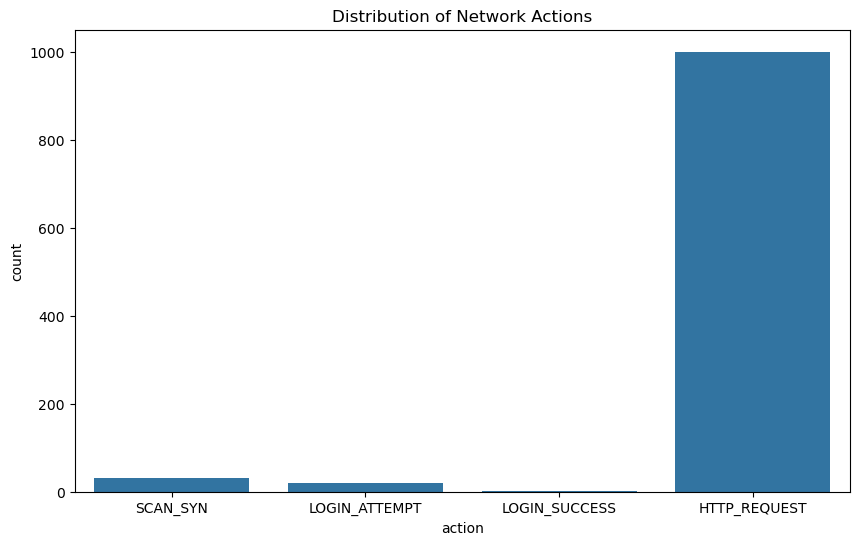

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(x='action', data=df)
plt.title('Distribution of Network Actions')
plt.show()

## 2. Intrusion Detection System (IDS) Logic

In [5]:
def detect_threats(df):
    threats = []
    
    # 1. DoS Detection: High volume of requests from single IP
    request_counts = df[df['action'] == 'HTTP_REQUEST']['source_ip'].value_counts()
    for ip, count in request_counts.items():
        if count > 100:  # Threshold
            threats.append({'IP': ip, 'Type': 'DoS Attack', 'Details': f'{count} requests detected'})

    # 2. Port Scan Detection: High number of unique ports scanned
    scan_df = df[df['action'] == 'SCAN_SYN']
    port_counts = scan_df.groupby('source_ip')['port'].nunique()
    for ip, count in port_counts.items():
        if count > 10: # Threshold
            threats.append({'IP': ip, 'Type': 'Port Scanning', 'Details': f'{count} unique ports scanned'})
            
    # 3. Brute Force Detection: High number of failed logins
    login_df = df[df['action'] == 'LOGIN_ATTEMPT']
    login_counts = login_df['source_ip'].value_counts()
    for ip, count in login_counts.items():
        if count > 5: # Threshold
            threats.append({'IP': ip, 'Type': 'Brute Force', 'Details': f'{count} failed attempts'})
            
    return pd.DataFrame(threats)

threats_df = detect_threats(df)
print("Detected Threats:")
print(threats_df)

Detected Threats:
             IP           Type                  Details
0  192.168.1.50     DoS Attack   1000 requests detected
1  192.168.1.50  Port Scanning  31 unique ports scanned
2  192.168.1.50    Brute Force       20 failed attempts


## 3. Threat Visualization

C:\Users\John\AppData\Local\Temp\ipykernel_5224\4052348165.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Type', data=threats_df, palette='Reds')


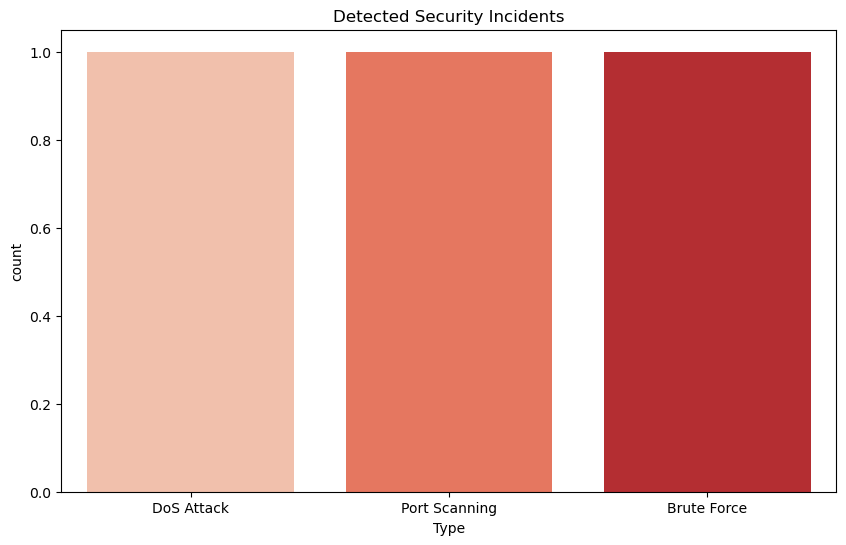

In [6]:
if not threats_df.empty:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Type', data=threats_df, palette='Reds')
    plt.title('Detected Security Incidents')
    plt.show()
else:
    print("No threats detected.")